In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)

In [6]:
pd.set_option('display.float_format', '{:.2%}'.format)

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
start_date = '2024-01-01'

data = yf.download(tickers, start=start_date, progress=False)['Close']
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma,
})
metricas.T

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA,TSLA
Rendimiento,12.49%,19.45%,14.10%,4.21%,75.47%,23.93%
Volatilidad,30.33%,32.03%,30.74%,23.51%,58.53%,68.95%


In [3]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [13]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns
    
    def black_scholes_price(self, So, K, T, rf, sigma, option_type='call'):
        d1 = (np.log(So / K) + (rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = (So * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rf * T) * norm.cdf(d2, 0.0, 1.0))
        else:
            price = (K * np.exp(-rf * T) * norm.cdf(-d2, 0.0, 1.0) - So * norm.cdf(-d1, 0.0, 1.0))
        return price

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i, ticker in enumerate(self.tickers):
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            #print(f'{ticker}')
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)

            k = self.strikes[i]

            premium_call = self.black_scholes_price(self.last_price[i], k, 1, 0.04, self.anual_sigma[i], 'call')
            premium_put = self.black_scholes_price(self.last_price[i], k, 1, 0.04, self.anual_sigma[i], 'put')

            long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
            long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
            strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

            self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

            for p in periods:
                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()

    def exec_prueba(self, periods=[20, 62, 125, 251], times=[1/12, 1/4, 1/2, 1]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i in range(len(self.tickers)):
            ticker = self.tickers[i]
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)            

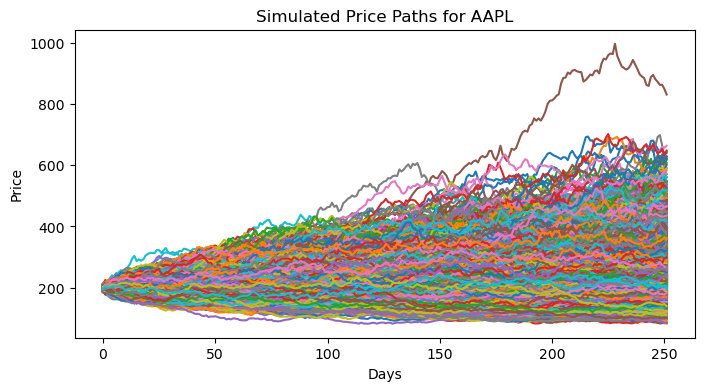

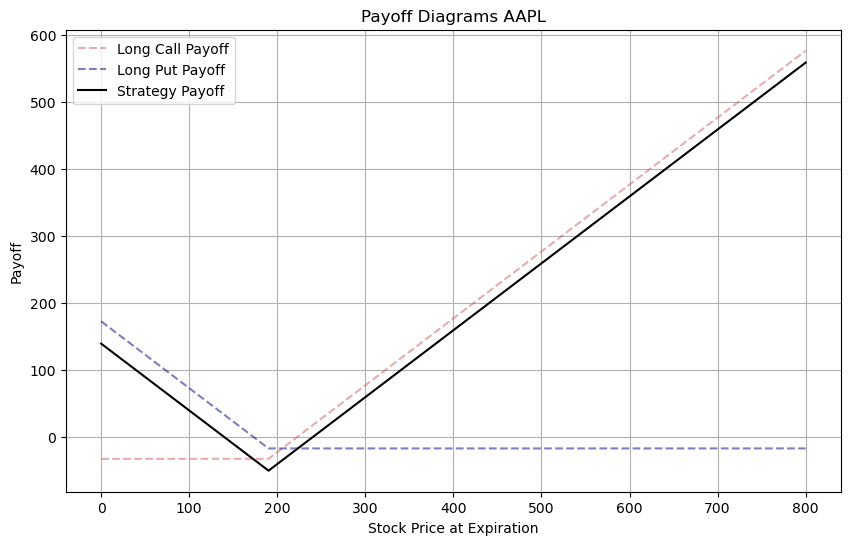

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.15
El rendimiento esperado de la estrategia es de -64.87%
El intervalo de confianza del 95% para el profit es de [-50.41043966605386, 1.3262820749387974]

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-19.85
El rendimiento esperado de la estrategia es de -38.85%
El intervalo de confianza del 95% para el profit es de [-49.975204139270915, 45.314791582188484]

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-3.87
El rendimiento esperado de la estrategia es de -7.57%
El intervalo de confianza del 95% para el profit es de [-49.467896349266596, 101.50644115395565]

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $26.91
El rendimiento esperado de la estrategia es de 52.67%
El intervalo de confianza del 95% para el profit es de [-48.5862659601548, 214.2963220930

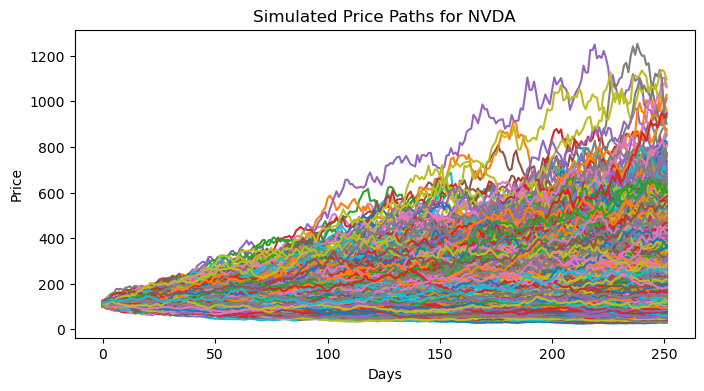

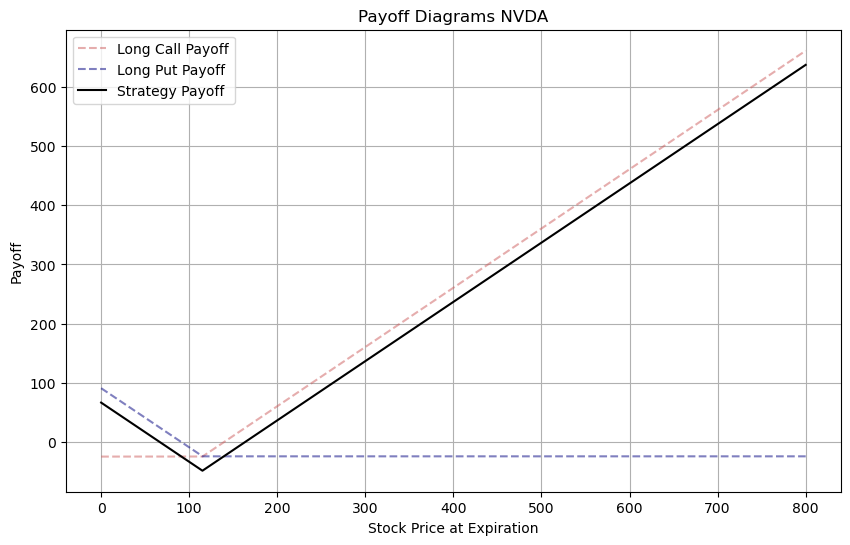

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-33.23
El rendimiento esperado de la estrategia es de -68.94%
El intervalo de confianza del 95% para el profit es de [-47.615847570145526, -4.031705001025468]

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-17.41
El rendimiento esperado de la estrategia es de -36.11%
El intervalo de confianza del 95% para el profit es de [-47.08425084489493, 55.90203142398451]

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $7.16
El rendimiento esperado de la estrategia es de 14.85%
El intervalo de confianza del 95% para el profit es de [-46.51451959764812, 151.5971615770695]

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $70.99
El rendimiento esperado de la estrategia es de 147.27%
El intervalo de confianza del 95% para el profit es de [-45.098171440950026, 401.83519002646

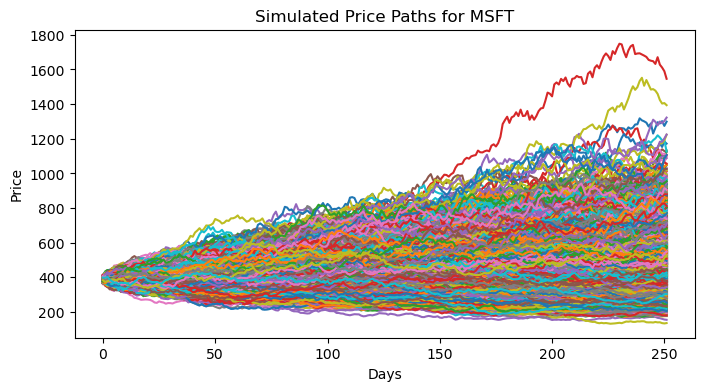

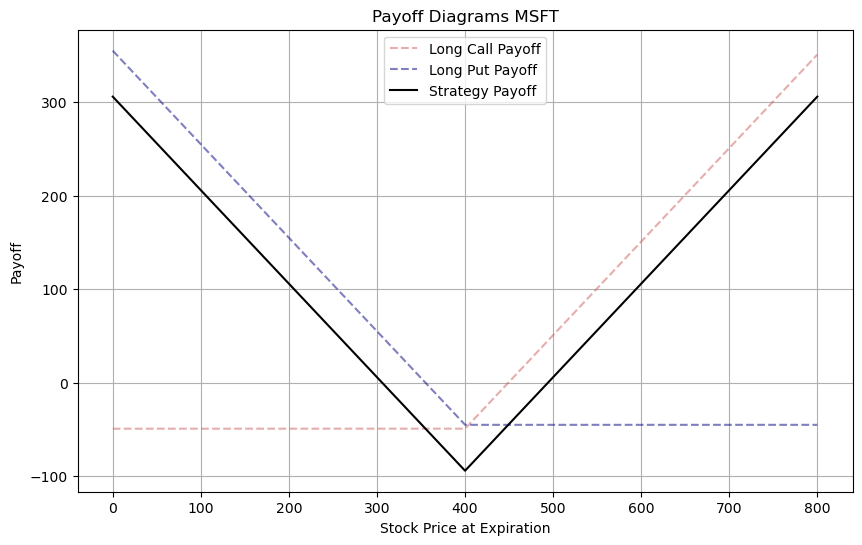

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-65.99
El rendimiento esperado de la estrategia es de -70.15%
El intervalo de confianza del 95% para el profit es de [-92.93463074725975, -16.117421813951008]

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-43.82
El rendimiento esperado de la estrategia es de -46.58%
El intervalo de confianza del 95% para el profit es de [-92.15217812976383, 53.711639136408294]

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-17.02
El rendimiento esperado de la estrategia es de -18.09%
El intervalo de confianza del 95% para el profit es de [-91.31141122364212, 153.9921205420395]

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $34.17
El rendimiento esperado de la estrategia es de 36.33%
El intervalo de confianza del 95% para el profit es de [-89.71980144010986, 344.497033051

In [11]:
straddle = MultiStraddle(['AAPL', 'NVDA', 'MSFT'], '2020-01-01', '2025-04-14', [190, 115, 400])
straddle.execute()

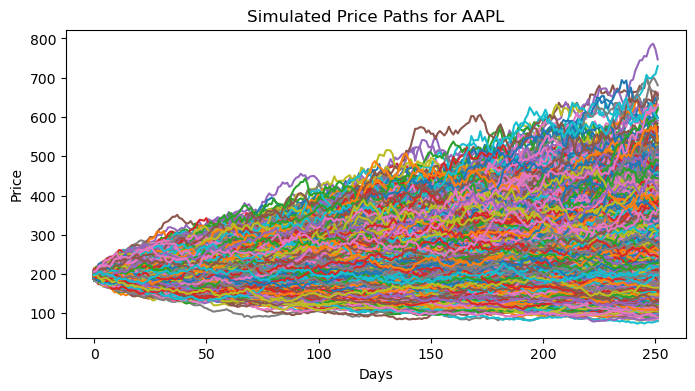

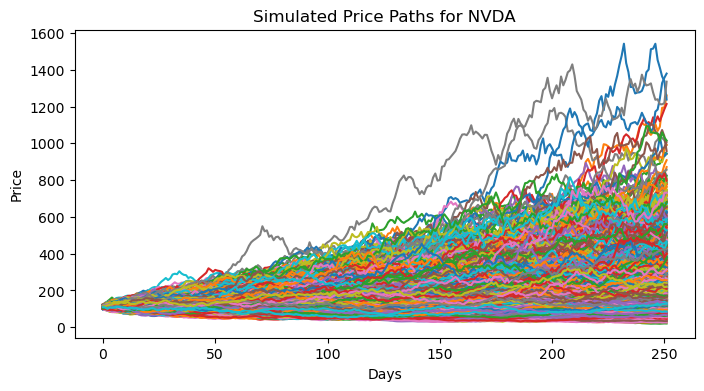

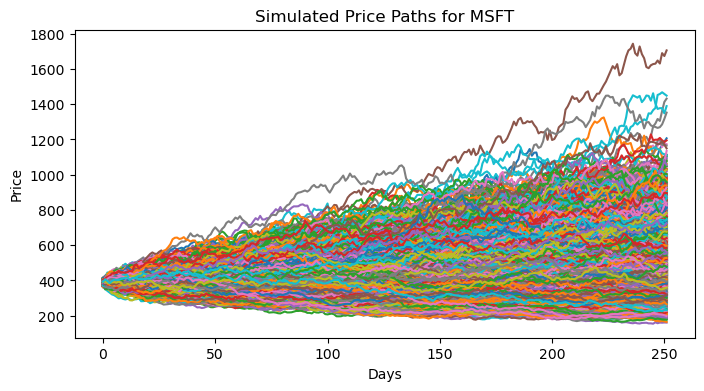

In [14]:
straddle = MultiStraddle(['AAPL', 'NVDA', 'MSFT'], '2020-01-01', '2025-04-14', [190, 115, 400])
straddle.exec_prueba()